In [1]:
# === STEP 1: Install Dependencies ===
!pip install -q torch torchvision timm albumentations seaborn scikit-learn pandas matplotlib tqdm

# === STEP 2: Import Libraries ===
import os
import math
import logging
from dataclasses import dataclass
from typing import Dict, Optional, List, Union

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights, ViT_B_16_Weights
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Follow the specified import pipeline for sklearn
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from google.colab import files

In [2]:
# === STEP 3: Setup and Configuration ===
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set device
if not torch.cuda.is_available():
    raise RuntimeError("GPU not available. Please go to Runtime > Change runtime type > Hardware accelerator > GPU")
device = torch.device("cuda")
logging.info(f"Using GPU: {torch.cuda.get_device_name(0)}")

# Constants
NUM_CLASSES = 10
PLOTS_DIR = "/content/plots"
os.makedirs(PLOTS_DIR, exist_ok=True)
COLOR_PALETTE = sns.color_palette("tab10")

In [3]:
# === STEP 4: LoRA Implementation ===
@dataclass
class LoRAConfig:
    r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.1
    target_modules: Optional[Union[List[str], str]] = None

class LoRALinear(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, rank: int = 8, alpha: float = 16.0, dropout: float = 0.0, use_bias: bool = False):
        super().__init__()
        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank
        self.weight = nn.Parameter(torch.empty(out_dim, in_dim))
        self.lora_a = nn.Parameter(torch.empty(rank, in_dim))
        self.lora_b = nn.Parameter(torch.empty(out_dim, rank))
        self.bias = nn.Parameter(torch.empty(out_dim)) if use_bias else None
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.lora_a, a=math.sqrt(5))
        nn.init.zeros_(self.lora_b)
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        result = F.linear(x, self.weight, self.bias)
        lora_result = F.linear(F.linear(self.dropout(x), self.lora_a), self.lora_b)
        return result + self.scaling * lora_result

def apply_lora(model: nn.Module, config: LoRAConfig) -> nn.Module:
    target_modules = config.target_modules or ['qkv', 'proj', 'fc1', 'fc2', 'fc', 'classifier', 'head']
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and any(target in name for target in target_modules):
            parent = model.get_submodule('.'.join(name.split('.')[:-1]))
            child_name = name.split('.')[-1]
            lora_layer = LoRALinear(
                in_dim=module.in_features,
                out_dim=module.out_features,
                rank=config.r,
                alpha=config.lora_alpha,
                dropout=config.lora_dropout,
                use_bias=module.bias is not None,
            )
            lora_layer.weight.data = module.weight.data.clone()
            if module.bias is not None:
                lora_layer.bias.data = module.bias.data.clone()
            setattr(parent, child_name, lora_layer)
    logging.info(f"Applied LoRA to modules containing: {config.target_modules}")
    return model

# --- FIX & ENHANCEMENT: Unified parameter freezing logic ---
def freeze_params(model: nn.Module, classifier_name: str):
    """Freezes all model parameters except for LoRA layers and the final classifier."""
    # Freeze all parameters initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze LoRA parameters and the classifier
    for name, param in model.named_parameters():
        if 'lora_a' in name or 'lora_b' in name or classifier_name in name:
            param.requires_grad = True

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    logging.info(f"Trainable params: {trainable:,} | Total params: {total:,} | Trainable %: {100 * trainable / total:.4f}")

In [4]:
# === STEP 5: Data Augmentations and Dataset ===
def get_transforms():
    return A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.Affine(translate_percent=(0.05, 0.05), scale=(0.9, 1.1), rotate=(-10, 10), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]), A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

class AlbumentationsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image.convert("RGB"))
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

In [5]:
# === STEP 6: Model Configurations ===
MODEL_CONFIGS: Dict[str, Dict] = {
    # Fine-tuning only the classifier head for CNNs
    'resnet50': {
        'builder': lambda: models.resnet50(weights=ResNet50_Weights.DEFAULT),
        'replace': ('fc', lambda: nn.Sequential(nn.Dropout(0.5), nn.Linear(2048, 1024), nn.ReLU(), nn.Linear(1024, NUM_CLASSES))),
        'opt': lambda m: optim.AdamW(filter(lambda p: p.requires_grad, m.parameters()), lr=1e-4, weight_decay=0.01),
        'lora': None  # No LoRA for this config
    },
    'efficientnet_b0': {
        'builder': lambda: models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT),
        'replace': ('classifier', lambda: nn.Sequential(nn.Dropout(0.5), nn.Linear(1280, 512), nn.SiLU(), nn.Linear(512, NUM_CLASSES))),
        'opt': lambda m: optim.AdamW(filter(lambda p: p.requires_grad, m.parameters()), lr=1e-4, weight_decay=0.01),
        'lora': None # No LoRA for this config
    },
    # LoRA applied to the Vision Transformer
    'vit_b16_lora': {
        'builder': lambda: models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1),
        'replace': ('heads.head', lambda: nn.Linear(768, NUM_CLASSES)),
        'opt': lambda m: optim.AdamW(filter(lambda p: p.requires_grad, m.parameters()), lr=3e-5, weight_decay=0.01),
        'lora': LoRAConfig(r=16, lora_alpha=32, lora_dropout=0.1, target_modules=['encoder.layers.'])
    }
}

In [6]:
# === STEP 7: Plotting Functions ===
def plot_learning_curves(history: dict, name: str):
    plt.figure(figsize=(12, 5))
    for i, metric in enumerate(['loss', 'accuracy']):
        plt.subplot(1, 2, i + 1)
        plt.plot(history[f'train_{metric}'], label=f'Train {metric.capitalize()}', color=COLOR_PALETTE[0])
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', color=COLOR_PALETTE[1])
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.title(f'{metric.capitalize()} Curves - {name}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f'learning_curves_{name}.png'), dpi=200)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, name: str):
    """Plots a confusion matrix using the 'tab10' colormap with black edges and hatches."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    # Use 'tab10' colormap, add black lines between cells
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='tab10', cbar=False,
                     linecolor='black', linewidths=0.5)

    # Add hatches for better visual distinction
    hatches = ['/', '\\', 'x', '-', '+', 'o', 'O', '.', '*']
    for i, patch in enumerate(ax.patches):
        # Apply a different hatch to each class's true-positive diagonal cell
        if (i // NUM_CLASSES) == (i % NUM_CLASSES):
             patch.set_hatch(hatches[i % len(hatches)])

    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(PLOTS_DIR, f'confusion_matrix_{name}.png'), dpi=200)
    plt.show()

def plot_multiclass_roc(y_true, y_scores, name: str, n_classes=10):
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.3f})', color='deeppink', linestyle='-', linewidth=2)

    colors = plt.cm.get_cmap('tab10', n_classes)
    for i, color in enumerate(colors.colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curve - {name}')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.savefig(os.path.join(PLOTS_DIR, f'roc_curve_{name}.png'), dpi=200)
    plt.show()

In [7]:
# === STEP 8: Training & Evaluation Functions ===
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total_samples = 0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    return total_loss / len(loader), correct / total_samples

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total_samples = 0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return total_loss / len(loader), correct / total_samples, all_labels, all_preds, np.array(all_probs)

In [8]:
# === STEP 9: Build Model Function ===
def build_model(config_key: str):
    config = MODEL_CONFIGS[config_key]
    model = config['builder']()

    replace_name, replace_layer = config['replace']
    model.get_submodule('.'.join(replace_name.split('.')[:-1])).__setattr__(replace_name.split('.')[-1], replace_layer())

    if config['lora'] is not None:
        model = apply_lora(model, config['lora'])

    freeze_params(model, classifier_name=replace_name)

    return model.to(device), config

In [9]:
# === STEP 10: Load Data ===
# --- MODIFICATION: Switched back to CIFAR10 dataset ---
transform_train, transform_val = get_transforms()
logging.info("Loading CIFAR-10 dataset...")
train_dataset = AlbumentationsDataset(datasets.CIFAR10(root='./data', train=True, download=True), transform=transform_train)
val_dataset = AlbumentationsDataset(datasets.CIFAR10(root='./data', train=False, download=True), transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

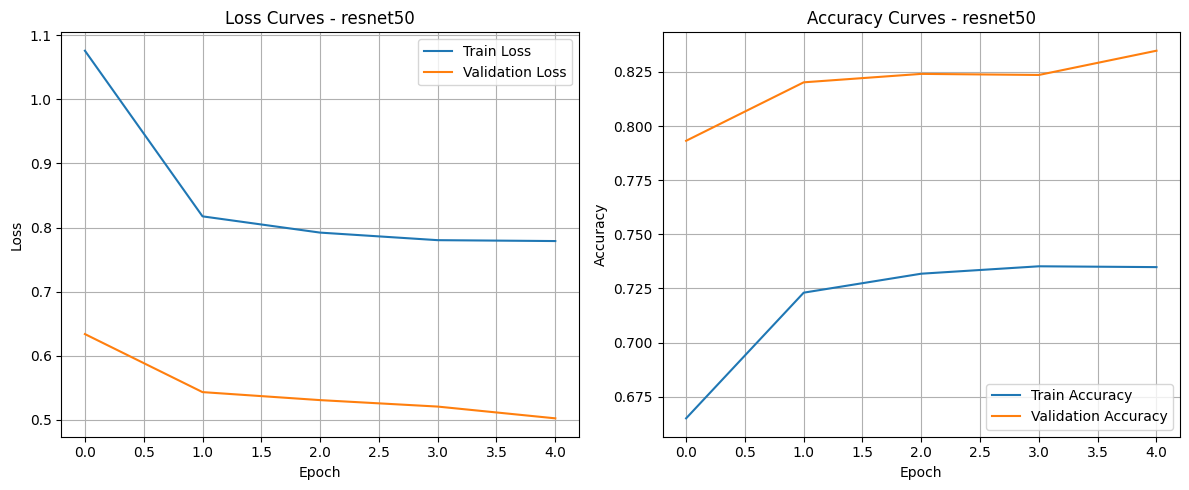

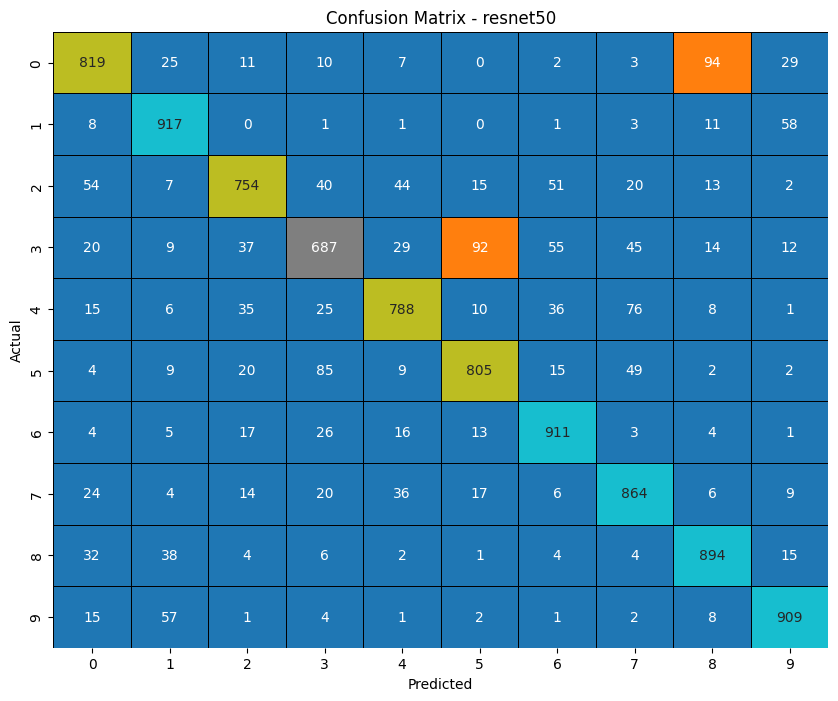

/tmp/ipython-input-2293434143.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


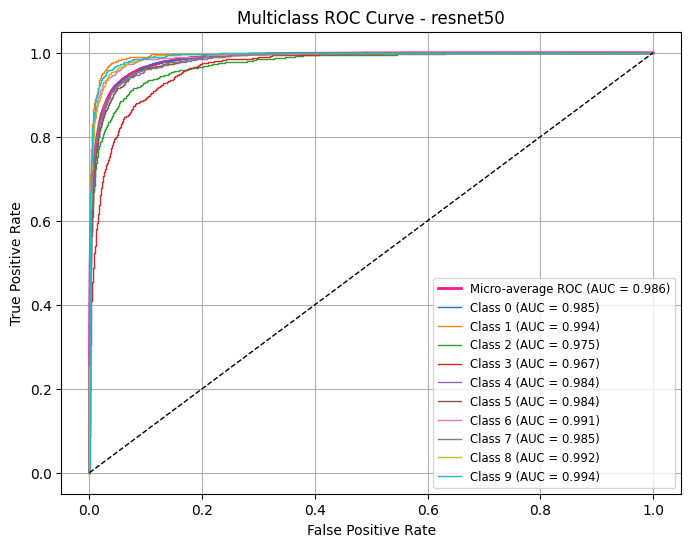

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 197MB/s]


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

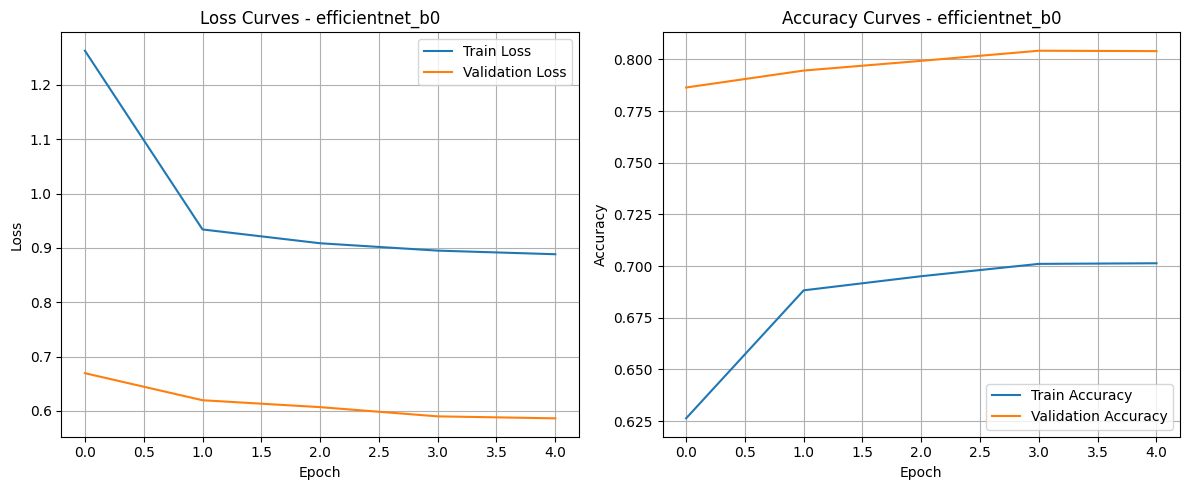

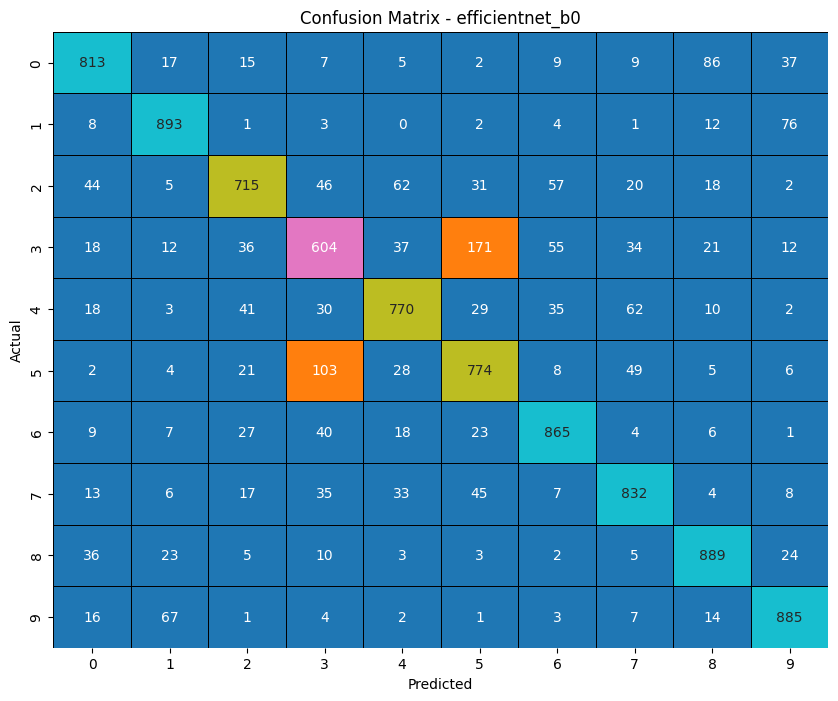

/tmp/ipython-input-2293434143.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


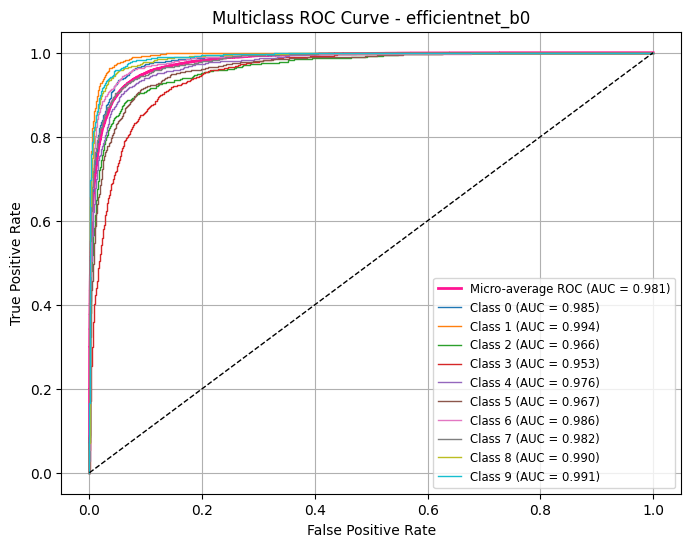

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:04<00:00, 74.9MB/s]


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

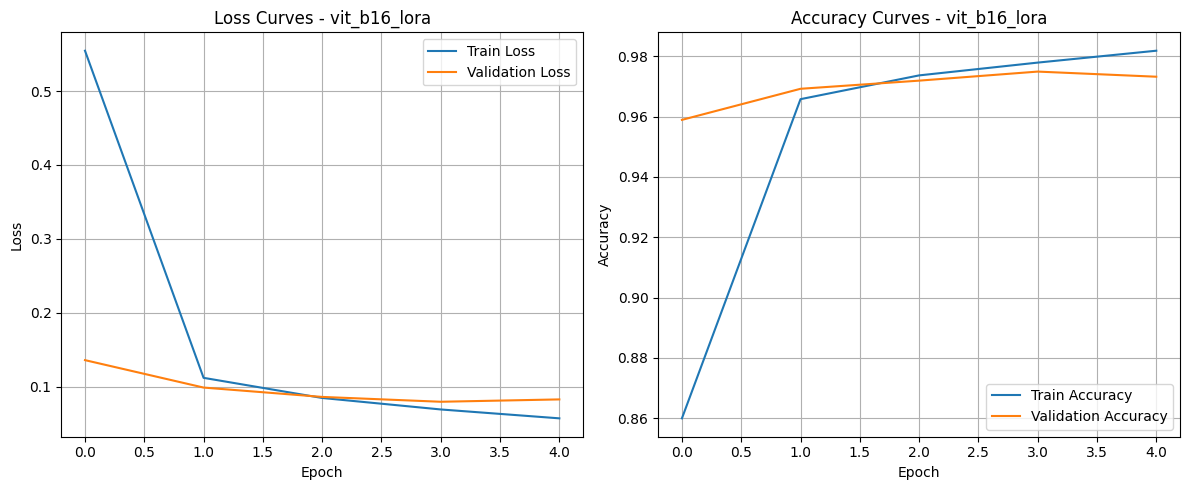

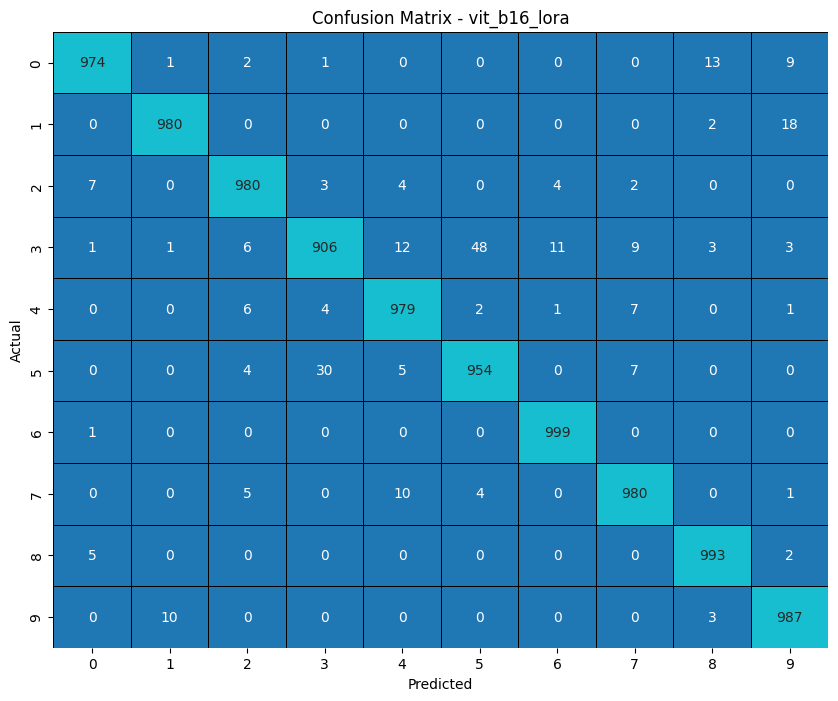

/tmp/ipython-input-2293434143.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


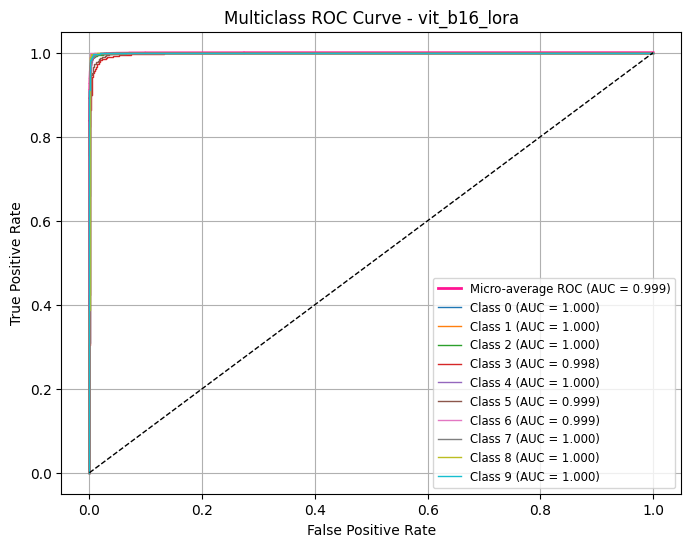

In [10]:
# === STEP 11: Benchmark All Models ===
results_list = []
all_reports_list = []
EPOCHS = 5

for model_name in MODEL_CONFIGS.keys():
    logging.info(f"\n🚀 Starting benchmark for {model_name}...")
    model, config = build_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = config['opt'](model)

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        logging.info(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    _, final_acc, y_true, y_pred, y_scores = evaluate(model, val_loader, criterion, device)

    report = classification_report(y_true, y_pred, output_dict=True, digits=4)

    # Convert report to DataFrame and store it
    report_df = pd.DataFrame(report).transpose()
    report_df['model'] = model_name
    all_reports_list.append(report_df)

    # Robust AUC calculation
    y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
    auc_micro = roc_auc_score(y_true_bin, y_scores, average='micro', multi_class='ovr')
    auc_macro = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')

    results_list.append({
        'Model': model_name,
        'Val Accuracy': final_acc,
        'F1-Score': report['weighted avg']['f1-score'],
        'AUC-Micro': auc_micro,
        'AUC-Macro': auc_macro,
        'Trainable Pct': (sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters())) * 100
    })

    plot_learning_curves(history, model_name)
    plot_confusion_matrix(y_true, y_pred, model_name)
    plot_multiclass_roc(y_true, y_scores, model_name)
    logging.info(f"✅ {model_name} completed.")

             Model  Val Accuracy  F1-Score  AUC-Micro  AUC-Macro  Trainable Pct
0     vit_b16_lora        0.9732  0.973074   0.999443   0.999390       2.029284
1         resnet50        0.8348  0.833401   0.985959   0.985130       8.230748
2  efficientnet_b0        0.8040  0.802422   0.980617   0.979041      14.158615
              precision  recall  f1-score     support            model
0              0.823116  0.8190  0.821053   1000.0000         resnet50
1              0.851439  0.9170  0.883004   1000.0000         resnet50
2              0.844345  0.7540  0.796619   1000.0000         resnet50
3              0.759956  0.6870  0.721639   1000.0000         resnet50
4              0.844587  0.7880  0.815313   1000.0000         resnet50
5              0.842932  0.8050  0.823529   1000.0000         resnet50
6              0.841959  0.9110  0.875120   1000.0000         resnet50
7              0.808232  0.8640  0.835186   1000.0000         resnet50
8              0.848197  0.8940  0.870497

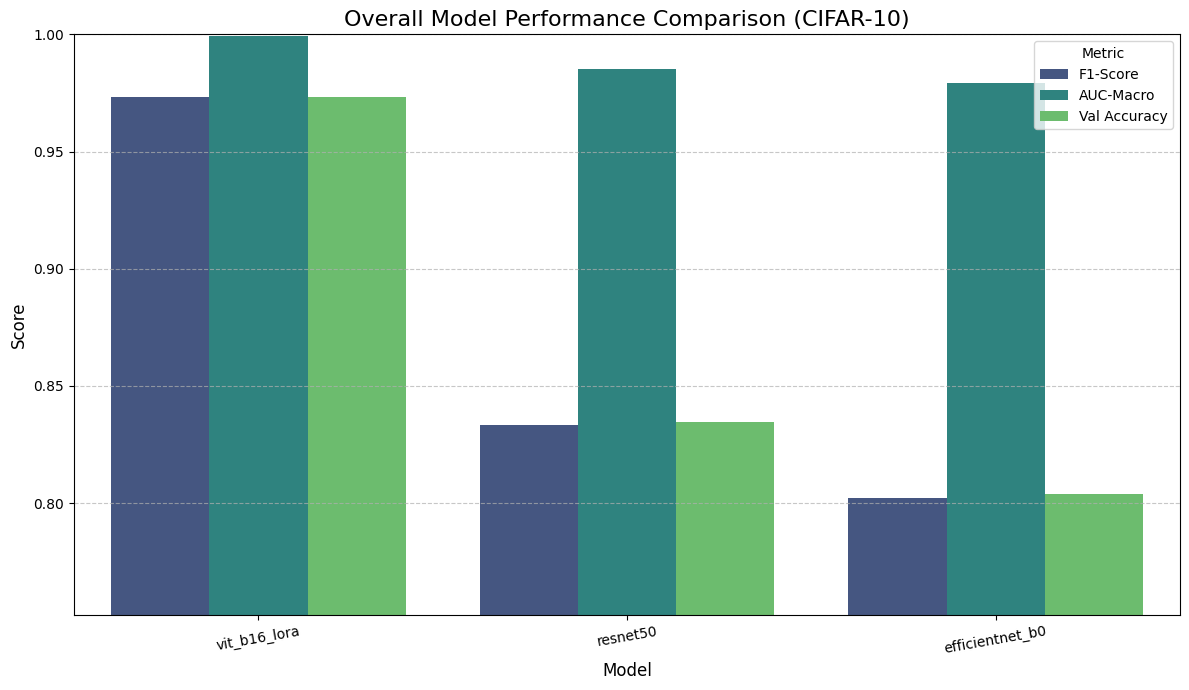

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# === STEP 12: Display, Save, and Plot Final Results ===
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)
logging.info("\n📊 Benchmark Results (CIFAR-10):")
print(results_df.to_string())

# Save to CSV
results_df.to_csv("/content/model_benchmark_cifar10.csv", index=False)
logging.info("\n💾 Saved benchmark results to /content/model_benchmark_cifar10.csv")

# Consolidate, display, and save detailed classification reports
detailed_reports_df = pd.concat(all_reports_list)
logging.info("\n📋 Detailed Classification Reports (All Models, CIFAR-10):")
print(detailed_reports_df.to_string())
detailed_reports_df.to_csv("/content/all_classification_reports_cifar10.csv")
logging.info("\n💾 Saved detailed reports to /content/all_classification_reports_cifar10.csv")


# --- ENHANCEMENT: Final comparison plot ---
def plot_benchmark_results(df):
    df_melted = df.melt(id_vars='Model', value_vars=['F1-Score', 'AUC-Macro', 'Val Accuracy'],
                            var_name='Metric', value_name='Score')

    plt.figure(figsize=(12, 7))
    sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette='viridis')
    plt.title('Overall Model Performance Comparison (CIFAR-10)', fontsize=16)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    min_score = df[['F1-Score', 'AUC-Macro', 'Val Accuracy']].min().min()
    plt.ylim(max(0, min_score - 0.05), 1.0) # Adjust ylim based on data
    plt.xticks(rotation=10)
    plt.legend(title='Metric')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'final_benchmark_comparison_cifar10.png'), dpi=200)
    plt.show()

plot_benchmark_results(results_df)

# Download all generated files
logging.info("\n⬇️ Downloading result files...")
files.download("/content/model_benchmark_cifar10.csv")
files.download("/content/all_classification_reports_cifar10.csv")
files.download("/content/plots/final_benchmark_comparison_cifar10.png")

In [12]:
!zip -r /content/plots.zip /content/plots
files.download('/content/plots.zip')

  adding: content/plots/ (stored 0%)
  adding: content/plots/roc_curve_vit_b16_lora.png (deflated 16%)
  adding: content/plots/confusion_matrix_efficientnet_b0.png (deflated 18%)
  adding: content/plots/learning_curves_vit_b16_lora.png (deflated 14%)
  adding: content/plots/final_benchmark_comparison_cifar10.png (deflated 24%)
  adding: content/plots/learning_curves_resnet50.png (deflated 14%)
  adding: content/plots/roc_curve_resnet50.png (deflated 15%)
  adding: content/plots/learning_curves_efficientnet_b0.png (deflated 16%)
  adding: content/plots/confusion_matrix_vit_b16_lora.png (deflated 22%)
  adding: content/plots/confusion_matrix_resnet50.png (deflated 17%)
  adding: content/plots/roc_curve_efficientnet_b0.png (deflated 13%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>